# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.6MB/s 


# Evn

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)


['data-20210420T111231Z-001.zip', 'kowiki']

# Data

In [ ]:
# 입력 문장
sentences = [
    "나는 학생 입니다",
    "당신은 수학 선생님 입니다",
    "나는 선생님 입니다",
    "당신은 수학 학생 입니다"
]

# 출력 정답
targets = [0,1,1,0]  # 학생(0), 선생님(1)

In [ ]:
id_to_label = {0: "학생", 1: "선생님"}

In [ ]:
train_src = sentences[:2]
train_tgt = targets[:2]

train_src, train_tgt

(['나는 학생 입니다', '당신은 수학 선생님 입니다'], [0, 1])

In [ ]:
valid_src = sentences[2:3]
valid_tgt = targets[2:3]

valid_src, valid_tgt

(['나는 선생님 입니다'], [1])

In [ ]:
test_src = sentences[3:]
test_tgt = targets[3:]

test_src, test_tgt

(['당신은 수학 학생 입니다'], [0])

# vocabulary

In [ ]:
words = []
for line in sentences:
    for w in line.split():
        words.append(w)

words = list(dict.fromkeys(words))
# words = dict.fromkeys(words)
words

['나는', '학생', '입니다', '당신은', '수학', '선생님']

In [ ]:
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'[PAD]': 0,
 '[UNK]': 1,
 '나는': 2,
 '당신은': 5,
 '선생님': 7,
 '수학': 6,
 '입니다': 4,
 '학생': 3}

In [ ]:
id_to_word = {_id:w for w, _id in word_to_id.items()}
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '나는',
 3: '학생',
 4: '입니다',
 5: '당신은',
 6: '수학',
 7: '선생님'}

# Train, Valid, Test 데이터 생성

In [ ]:
def make_data(src, tgt, n_seq):
    inputs, labels = [], []

    for s, t in zip(src, tgt):
        # print(s)
        print(t)
        _input = [word_to_id[w] for w in s.split()]
        _input = _input[:n_seq]
        _input = _input + [0] * (n_seq - len(_input))
        inputs.append(_input)

        _label = t
        labels.append(_label)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(train_src, train_tgt, 5)
train_inputs, train_labels

0
1


(array([[2, 3, 4, 0, 0],
        [5, 6, 7, 4, 0]]), array([0, 1]))

In [ ]:
valid_inputs, valid_labels = make_data(valid_src, valid_tgt, 6)
valid_inputs, valid_labels

1


(array([[2, 7, 4, 0, 0, 0]]), array([1]))

In [ ]:
test_inputs, test_labels = make_data(test_src, test_tgt, 4)
test_inputs, test_labels

0


(array([[5, 6, 3, 4]]), array([0]))

# Modeling

In [ ]:
train_inputs = np.random.randint(0, 8, (2, 5))
train_labels = np.random.randint(0, 2, (2,))
train_inputs, train_labels

(array([[5, 0, 1, 0, 0],
        [4, 6, 0, 6, 4]]), array([0, 1]))

In [ ]:
valid_inputs = np.random.randint(0, 8, (1, 6))
valid_labels = np.random.randint(0, 2, (1))
valid_inputs, valid_labels

(array([[7, 1, 2, 5, 6, 2]]), array([1]))

In [ ]:
test_inputs = np.random.randint(0, 8, (1, 4))
test_labels = np.random.randint(0, 2, (1))
test_inputs, test_labels

(array([[5, 6, 7, 4]]), array([1]))

In [ ]:
embedding = tf.keras.layers.Embedding(len(word_to_id), 3)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 5, 3), dtype=float32, numpy=
array([[[-0.01878542,  0.02515935, -0.01021639],
        [-0.0228891 , -0.01006486, -0.04771255],
        [ 0.00926401,  0.04009868, -0.03501823],
        [-0.0228891 , -0.01006486, -0.04771255],
        [-0.0228891 , -0.01006486, -0.04771255]],

       [[ 0.03785111,  0.00722358,  0.03167399],
        [-0.03761582,  0.04714661,  0.0157624 ],
        [-0.0228891 , -0.01006486, -0.04771255],
        [-0.03761582,  0.04714661,  0.0157624 ],
        [ 0.03785111,  0.00722358,  0.03167399]]], dtype=float32)>

In [ ]:
weight = embedding.get_weights()[0]
weight

array([[-0.0228891 , -0.01006486, -0.04771255],
       [ 0.00926401,  0.04009868, -0.03501823],
       [-0.03032173,  0.02436017, -0.0146642 ],
       [ 0.01639814, -0.03328501, -0.00766789],
       [ 0.03785111,  0.00722358,  0.03167399],
       [-0.01878542,  0.02515935, -0.01021639],
       [-0.03761582,  0.04714661,  0.0157624 ],
       [-0.03124894,  0.03201384,  0.0077284 ]], dtype=float32)

In [ ]:
weight[train_inputs]

array([[[-0.01878542,  0.02515935, -0.01021639],
        [-0.0228891 , -0.01006486, -0.04771255],
        [ 0.00926401,  0.04009868, -0.03501823],
        [-0.0228891 , -0.01006486, -0.04771255],
        [-0.0228891 , -0.01006486, -0.04771255]],

       [[ 0.03785111,  0.00722358,  0.03167399],
        [-0.03761582,  0.04714661,  0.0157624 ],
        [-0.0228891 , -0.01006486, -0.04771255],
        [-0.03761582,  0.04714661,  0.0157624 ],
        [ 0.03785111,  0.00722358,  0.03167399]]], dtype=float32)

In [ ]:
# RNN, CNN, Attention

In [ ]:
pool = tf.keras.layers.GlobalMaxPooling1D()
hidden = pool(hidden)
hidden

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.00926401,  0.04009868, -0.01021639],
       [ 0.03785111,  0.04714661,  0.03167399]], dtype=float32)>

In [ ]:
linear = tf.keras.layers.Dense(2)
logits = linear(hidden)
logits

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.04032616,  0.0457767 ],
       [-0.01881896,  0.01685425]], dtype=float32)>

In [ ]:
# y = Wx + b
weight, bias = linear.get_weights()
weight, bias

(array([[ 0.45690572,  0.32294822],
        [-1.0163004 ,  0.80061126],
        [ 0.3726014 , -1.0455203 ]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
tf.matmul(hidden, weight) + bias

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.04032616,  0.0457767 ],
       [-0.01881896,  0.01685425]], dtype=float32)>

In [ ]:
y_pred = tf.nn.softmax(logits, axis=-1)
y_pred

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.47848758, 0.52151245],
       [0.4910826 , 0.50891733]], dtype=float32)>

In [ ]:
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
y_pred = linear(hidden)
y_pred

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4943787 , 0.50562125],
       [0.48183218, 0.5181678 ]], dtype=float32)>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args.n_out = 2
args

Namespace(d_model=32, n_out=2, n_vocab=8, seed=1234)

In [ ]:
def build_model(args):

    inputs = tf.keras.layers.Input((None,))
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    pool = tf.keras.layers.GlobalMaxPooling1D()
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)

    hidden = embedding(inputs)
    #
    # RNN, CNN, Attention, Linear
    #
    hidden = pool(hidden)

    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

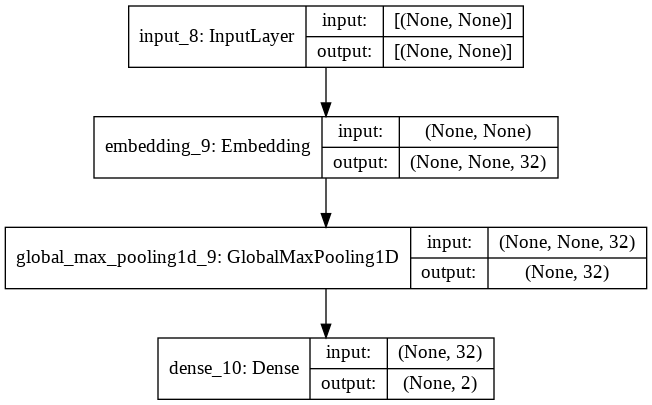

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

array([[0.51790667, 0.48209336],
       [0.5250456 , 0.4749544 ]], dtype=float32)

In [ ]:
model.predict(valid_inputs)

array([[0.5377, 0.4623]], dtype=float32)

In [ ]:
model.predict(test_inputs)

array([[0.52817965, 0.47182035]], dtype=float32)

# Train

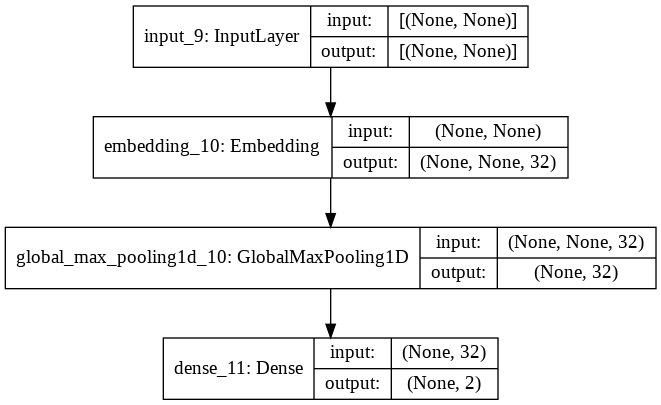

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
train_inputs.shape, train_labels.shape, valid_inputs.shape, valid_labels.shape

((2, 5), (2,), (1, 6), (1,))

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint("stub.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("stub.csv")

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=8,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 1s 595ms/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.7086 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to stub.hdf5
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.6843 - accuracy: 0.5000 - val_loss: 0.7083 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 0.6804 - accuracy: 1.0000 - val_loss: 0.7080 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 0.6767 - accuracy: 1.0000 - val_loss: 0.7081 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 0.6730 - accuracy: 1.0000 - val_loss: 0.7084 - val_accuracy: 0.0000e+00

Epoch 00005: val_accuracy 

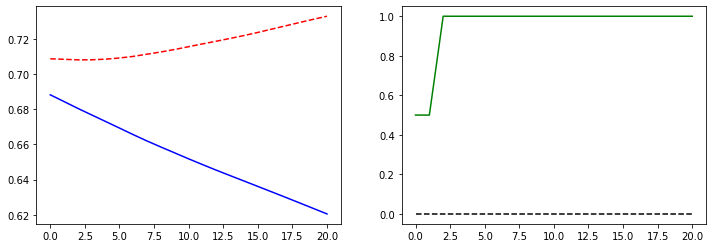

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

# 평가

In [ ]:
model = build_model(args)
model.load_weights("stub.hdf5")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 192ms/step - loss: 0.6928 - accuracy: 1.0000


[0.6928495168685913, 1.0]

# 배포

In [ ]:
model = build_model(args)
model.load_weights("stub.hdf5")

In [ ]:
string = "수학 당신은 선생님 입니다"

In [ ]:
infer_input = [word_to_id[w] for w in string.split()]
infer_input = np.array([infer_input]) # 현재 배치가 1인 데이터
infer_input

array([[6, 5, 7, 4]])

In [ ]:
train_inputs.shape, infer_input.shape

((2, 5), (1, 4))

In [ ]:
y_pred = model.predict(infer_input)
y_pred

# 오늘은 문장단위니까 1개

array([[0.49985114, 0.50014883]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1])

In [ ]:
for val in y_class:
    print(f"{val} : {id_to_label[val]}")

1 : 선생님


In [ ]:
def do_predict(model, string):
    tokens = string.split()
    infer_input = []
    for w in tokens:
        infer_input.append(word_to_id.get(w, 1))
        # infer_input.append(word_to_id.[w]
    infer_input = np.array([infer_input])
    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    # return y_class
    # result = []
    # for w, c in zip(tokens, y_class):
    #     result.append([w, id_to_label[c]])
    return [string, id_to_label[y_class]]

In [ ]:
do_predict(model, "수학 당신은 과학 선생님 입니다")

['수학 당신은 과학 선생님 입니다', '학생']

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 나는 중학생 입니다
['나는 중학생 입니다', '학생']
input> 나는 중학생입니다
['나는 중학생입니다', '학생']
input> 나는 중학생 입니다
['나는 중학생 입니다', '학생']
input> 

KeyboardInterrupt: ignored

In [ ]:
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '나는',
 3: '학생',
 4: '입니다',
 5: '당신은',
 6: '수학',
 7: '선생님'}